In [2]:
## Cullan's code: only using Pgg info
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":

    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = newFish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = newFish(
                cosmo,
                cosmo.kmax,
                np.repeat(0.5,len(cosmo.z)),
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )
FullCatch1=FullCatch
# using BAO_ONLY=TRUE: changes results!!!
# convert number/ sqdeg/redshift bin, create new data.txt
# 10 -3 should be seeing.

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04578811 0.04581033]] [[0.01068541 0.00275782]]
#  Data bias
[[1.35777062 1.39418108]]
#  Data recon factor
[0.5 0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)


TypeError: newFish() takes from 7 to 8 positional arguments but 9 were given

In [ ]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)

#pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar, data.nbarz)
print("#  Data bias")
print(data.bias)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
recon=np.ones_like(recon)
print(recon)

print("#  Kmins")
print(cosmo.kmin)

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
print(
    "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = newFish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
        )

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = newFish(
            cosmo,
            cosmo.kmax,
            np.repeat(0.5,len(cosmo.z)),
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
            #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
        )

        # Output the fisher matrix for the redshift bin
        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data
# integral for mu is -1 to 1
# 0.04 -> 0.0001
# compare four cases: 1 bin, 2 bins, with pvs vs without, without should match desi paper
# impact of no bao recon -> set recon factor to 1, also try BAO only = false
# use kmax .2 dont add info beyond that
# try 1 bin from 0 to 0.05 make sure same result

# 10-25% imrpovement using PVs
# 2 bin WITH PVs
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       10.75         107.9       12.59        68.2       9.33       7.458
# 0.075    0.0310     0.446       11.80         304.9       6.99        69.9       14.12       5.131
#  Combined errors
#=================
# 0.05    0.0356     0.441       7.927         209.40       6.010        69.01       7.525       3.825

# 2 bin WITHOUT PVs
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       88.97         107.9       18.63        68.2       38.88       13.828
# 0.075    0.0310     0.446       33.63         304.9       7.06        69.9       14.83       5.260
#  Combined errors
#=================
# 0.05    0.0356     0.441       31.742         209.40       6.604        69.01       13.858       4.916

# 1 bin WITH PVs
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       6.83         209.4       6.45        69.0       11.73       4.538
#  Combined errors
#=================
# 0.05    0.0356     0.441       6.831         209.40       6.447        69.01       11.728       4.538

# 1 bin WITHOUT PVs
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       31.64         209.4       6.65        69.0       13.92       4.944
#  Combined errors
#=================
# 0.05    0.0356     0.441       31.636         209.40       6.648        69.01       13.923       4.944

# 2 bin WITH PVs, FALSE
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       11.00         107.9       1.36        68.2       1.36       1.357
# 0.075    0.0310     0.446       13.54         304.9       4.09        69.9       4.09       4.082
#  Combined errors
#=================
# 0.05    0.0356     0.441       8.220         209.40       1.289        69.01       1.287       1.288

# 2 bin WITHOUT PVs, FALSE
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       113.70         107.9       17.48        68.2       35.06       13.347
# 0.075    0.0310     0.446       42.98         304.9       6.66        69.9       13.45       5.057
#  Combined errors
#=================
# 0.05    0.0356     0.441       40.564         209.40       6.225        69.01       12.554       4.729

# 1 bin, WITH PVs, FALSE
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       7.38         209.4       1.64        69.0       1.63       1.635
#  Combined errors
#=================
# 0.05    0.0356     0.441       7.380         209.40       1.636        69.01       1.635       1.635

# 1 bin, WITHOUT PVs, FALSE
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       40.45         209.4       6.26        69.0       12.58       4.742
#  Combined errors
#=================
# 0.05    0.0356     0.441       40.448         209.40       6.256        69.01       12.584       4.742

# 1 bin, WITHOUT PVs, recon=1
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       40.55         209.4       15.30        69.0       39.08       12.896
#  Combined errors
#=================
# 0.05    0.0356     0.441       40.546         209.40       15.295        69.01       39.076       12.896

# 1 bin, WITH PVs, recon=1
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.050    0.0356     0.441       7.85         209.4       14.10        69.0       22.85       9.680
#  Combined errors
#=================
# 0.05    0.0356     0.441       7.847         209.40       14.102        69.01       22.848       9.680

# 2 bin, WTIHOUT PVs, recon=1
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       114.90         107.9       43.25        68.2       109.62       36.269
# 0.075    0.0310     0.446       43.06         304.9       16.10        69.9       41.44       13.647
#  Combined errors
#=================
# 0.05    0.0356     0.441       40.683         209.40       15.090        69.01       38.763       12.772

# 2 bin, WITH PVs, recon=1
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
# 0.025    0.0046     0.435       13.09         107.9       19.20        68.2       11.86       11.217
# 0.075    0.0310     0.446       13.60         304.9       15.66        69.9       35.07       12.336
#  Combined errors
#=================
# 0.05    0.0356     0.441       9.418         209.40       11.920        69.01       10.584       7.210

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04578811 0.04581033]] [[0.01068541 0.00275782]]
#  Data bias
[[1.35777062 1.39418108]]
#  Data recon factor
[1. 1.]
#  Kmins
[0.02958362 0.01894654]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.025    0.0046     0.435       13.09         107.9       19.20        68.2       11.86       11.217
 0.075    0.0310     0.446       13.60         304.9       15.66        69.9       35.07       12.336
#  Combined errors
#=================
 0.05    0.0356     0.441       9.418         209.40       11.920        69.01       10.584       7.210


In [23]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['f$\sigma_8$', 'D$_A$', 'H']#['DESI, 2016','1 bin, no PVs','1 bin, with PVs','2 bins, no PVs','2 bins, with PVs']
desi = [33.24, 6.12, 12.1]#[12.1]
colors = ['k','lightblue','b','lightcoral','r']

# recon = 1
#no1 = [40.546, 15.295, 39.076]
#no2 = [40.683, 15.090, 38.763]
#pv1 = [7.847, 14.102, 22.848]
#pv2 = [9.418, 11.920, 10.584]

# bao only = true
#no1 = [13.92]#[31.64, 6.65, 13.92]
#no2 = [13.86]#[31.74, 6.60, 13.86]
#pv1 = [11.73]#[6.83, 6.48, 11.73]
#pv2 = [7.53]#[7.93, 6.01, 7.53]

# bao only = false
no1 = [40.448, 6.256, 12.584]
no2 = [40.564, 6.225, 12.554]
pv1 = [7.380, 1.636, 1.287]
pv2 = [8.220, 1.289, 1.635]

x = np.arange(len(labels)) 
width = 0.1 

fig, ax = plt.subplots(figsize=(8,6))
#ax.bar(x,desi+no1+pv1+no2+pv2,width,color=colors)
ax.bar(x - 2*width-0.05, desi, width, label='DESI, 2016',color='k')
ax.bar(x - width, no1, width, label='1 bin, no PVs',color='lightblue')
ax.bar(x, pv1, width, label='1 bin, with PVs',color='b')
ax.bar(x + width+0.05, no2, width, label='2 bins, no PVs',color='lightcoral')
ax.bar(x + 2*width+0.05, pv2, width, label='2 bins, with PVs',color='r')

ax.set_ylabel('Uncertainty (%)',fontsize=16)
#ax.set_ylim(0,18)
ax.set_title('Estimated Uncertainty in Cosmological Parameters \n (BAO Only = False)',fontsize=20)
ax.set_xlabel('Forecast',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()

plt.tight_layout()
path='../Figures/BAOOnlyFalse.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close()

In [3]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)

#pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar, data.nbarz)
print("#  Data bias")
print(data.bias)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
print(recon)

print("#  Kmins")
print(cosmo.kmin)

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
print(
    "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = newFish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
        )

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = newFish(
            cosmo,
            cosmo.kmax,
            np.repeat(0.5,len(cosmo.z)),
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
            #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
        )

        # Output the fisher matrix for the redshift bin
        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data
# integral for mu is -1 to 1
# 0.04 -> 0.0001

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04578811 0.04581033]] [[0.01068541 0.00275782]]
#  Data bias
[[1.35777062 1.39418108]]
#  Data recon factor
[0.5 0.5]
#  Kmins
[0.02958362 0.01894654]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.025    0.0046     0.435       10.75         107.9       12.59        68.2       9.33       7.458
 0.075    0.0310     0.446       11.80         304.9       6.99        69.9       14.12       5.131
#  Combined errors
#=================
 0.05    0.0356     0.441       7.927         209.40       6.010        69.01       7.525       3.825


In [2]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)

#pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# add line btw convert nbar and scale bias
# compute kmin for each z bin
# add function in input, data.computekmin

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar, data.nbarz)
print("#  Data bias")
print(data.bias)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
print(recon)

print('#  Kmins')
print(cosmo.kmin)

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
print(
    "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = newFish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
        )

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = newFish(
            cosmo,
            cosmo.kmax,
            0.5,
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
            #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
        )

        # Output the fisher matrix for the redshift bin
        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data
# integral for mu is -1 to 1
# 0.04 -> 0.001


/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04578811 0.04581033]] [[0.01068541 0.00275782]]
#  Data bias
[[1.35777062 1.39418108]]
#  Data recon factor
[0.5 0.5]
#  Kmins
[0.02958362 0.01894654]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)


TypeError: 'float' object is not subscriptable

In [2]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)

#pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar, data.nbarz)
print("#  Data bias")
print(data.bias)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
print(recon)

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
print(
    "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = newFish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
        )

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = newFish(
            cosmo,
            cosmo.kmax,
            0.5,
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
            #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
        )

        # Output the fisher matrix for the redshift bin
        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data
# integral for mu is -1 to 1

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04580784]] [[0.00378259]]
#  Data bias
[[1.37583381]]
#  Data recon factor
[0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.050    0.0356     0.441       6.31         209.4       6.43        69.0       11.45       4.493
#  Combined errors
#=================
 0.05    0.0356     0.441       6.308         209.40       6.430        69.01       11.453       4.493


In [28]:
from TackleBox import get_powerfx, get_inv_cov,get_full_deriv,compute_deriv_alphas
from scipy.interpolate import splrep, splev
kvec = np.linspace(cosmo.kmin,cosmo.kmax,100)
muvec = np.linspace(-1,1,200)
pgg=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgg at each k and mu value
pgu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgu at each k and mu value
puu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of puu at each k and mu value
cov=np.zeros((3,3,len(kvec),len(muvec))) # covariance info, 3x3 for Pgg Pgu Puu and then k and mu
invcov=np.zeros((3,3,len(kvec),len(muvec))) # inverse covariance info
bder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt b at each k and mu value
fder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt f at each k and mu value
aperder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt aperp at each k and mu value
aparder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt apara at each k and mu value

In [29]:
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
coords = [[kval, muval] for kval in kvec for muval in muvec]
kaiser = np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)])

In [30]:
fval,zval,hval,nbarval,vbarval,pverr,vol,dk,da,sigmaval=cosmo.f[0],cosmo.z[0],cosmo.h[0],data.nbar[0,0],data.nbarz[0,0],data.pverr[0,0],cosmo.volume[0],kvec[1]-kvec[0],cosmo.da[0],cosmo.sigma8[0]
# adjust power spectra # spline interp # also plotting monopole # instead of choosing mu, integrate over mu w no weighting
# take pgg ij integrate over mu to get pgg i then pass that into cov matrix
for i, kval in enumerate(kvec):
    for j, muval in enumerate(muvec):
        pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)
        cov[:,:,i,j],invcov[:,:,i,j]=get_inv_cov(pgg[i,j],pgu[i,j],puu[i,j],nbarval,vbarval,pverr,da,hval,dk)
        info=get_full_deriv(kval,muval,pkval[i],pksmoothval[i],kaiser[:,j],fval,zval,hval,derPalphaval[:,i,j],sigmaval) # then multiply by Dfactor**2 -> same for 4, different for power spec, make them the same for now.
        bder[:,i,j],fder[:,i,j],aperder[:,i,j],aparder[:,i,j]=info[:,0],info[:,1],info[:,2],info[:,3]

/tmp/ipykernel_5274/374363864.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)


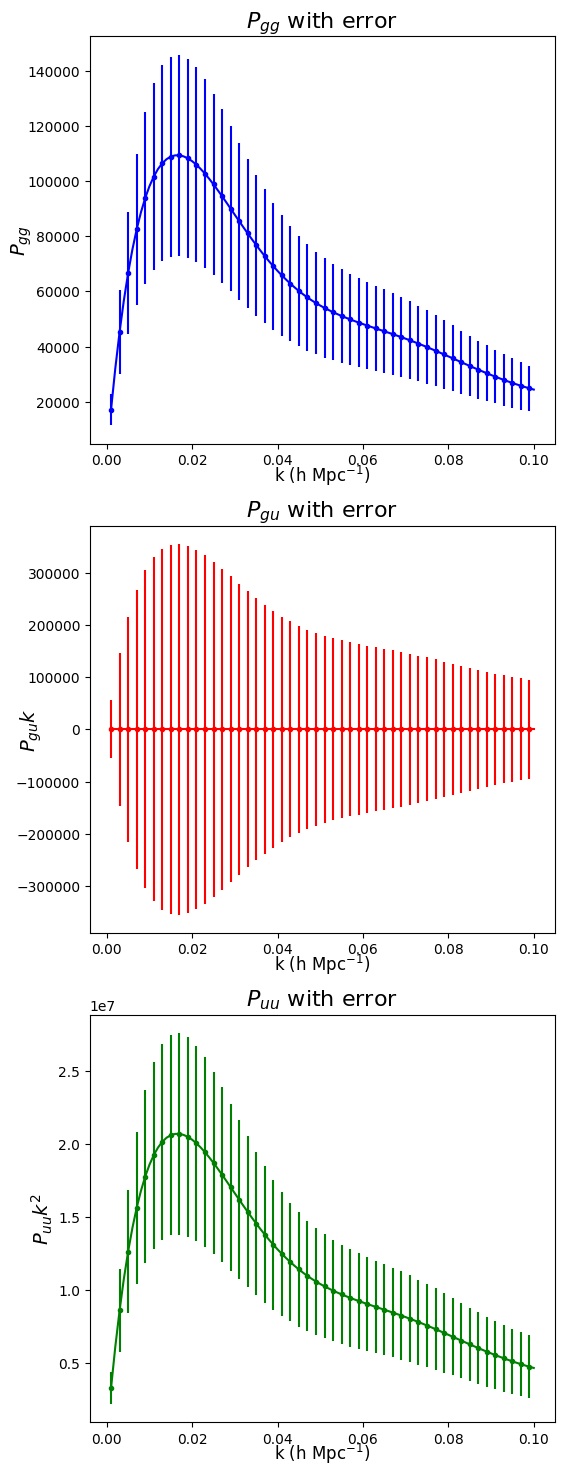

In [37]:
import scipy.integrate
results1=scipy.integrate.simpson(pgg,muvec,axis=1)
results2=scipy.integrate.simpson(pgu,muvec,axis=1)
results3=scipy.integrate.simpson(puu,muvec,axis=1)
import matplotlib.pyplot as plt
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
factor=(2*np.pi**2)/(vol*kval**2*(kvec[1]-kvec[0]))
ps=pverr*da*hval
cgg=factor*2*(results1+1/nbarval)**2
cgu=factor*(results1+1/nbarval)*(results3+ps**2/vbarval)+results2**2
cuu=factor*2*(results3+ps**2/vbarval)**2
s=2
#axes[0].errorbar(kvec[::5],(results1*kvec)[::5],yerr=(np.sqrt(cgg)*kvec)[::5],fmt='.',color='b')
axes[0].errorbar(kvec[::s],results1[::s],yerr=np.sqrt(cgg)[::s],fmt='.',color='b')
axes[1].errorbar(kvec[::s],(results2*kvec)[::s],yerr=(np.sqrt(cgu)*kvec)[::s],fmt='.',color='r')
axes[2].errorbar(kvec[::s],(results3*kvec**2)[::s],yerr=(np.sqrt(cuu)*kvec**2)[::s],fmt='.',color='g')
axes[0].plot(kvec,results1,color='b')
axes[1].plot(kvec,results2*kvec,color='r')
axes[2].plot(kvec,results3*kvec**2,color='g')
axes[0].set_title('$P_{gg}$ with error',fontsize=16)
axes[1].set_title('$P_{gu}$ with error',fontsize=16)
axes[2].set_title('$P_{uu}$ with error',fontsize=16)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_ylabel('$P_{gg}$',fontsize=14,labelpad=-5)
axes[1].set_ylabel('$P_{gu}k$',fontsize=14,labelpad=-20)
axes[2].set_ylabel('$P_{uu}k^2$',fontsize=14,labelpad=2)
path = '../Figures/FinalPower.png'
plt.show()
#plt.savefig(path, dpi=300,bbox_inches='tight')
#plt.close()

# number/sq degree /width of bin

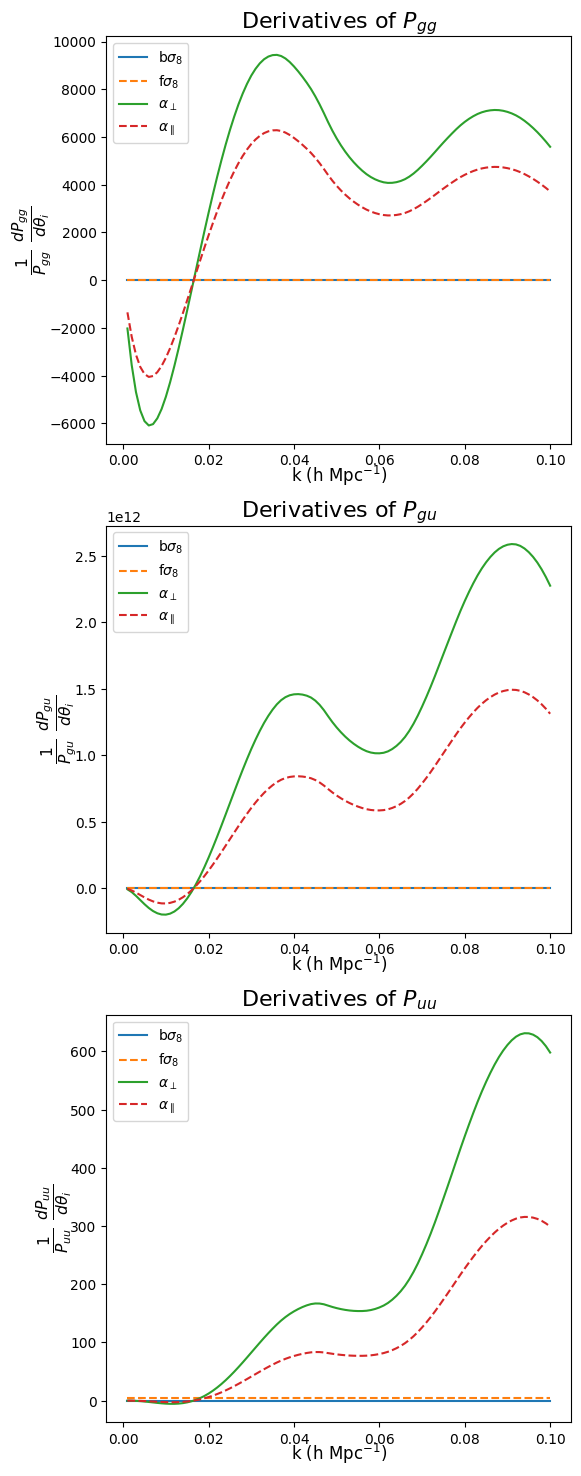

In [38]:
newbder=scipy.integrate.simpson(bder,muvec,axis=2)
newfder=scipy.integrate.simpson(fder,muvec,axis=2)
newapder=scipy.integrate.simpson(aperder,muvec,axis=2)
newalder=scipy.integrate.simpson(aparder,muvec,axis=2)
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
axes[0].plot(kvec,newbder[0,:]/results1,label='b$\sigma_8$')
axes[0].plot(kvec,newfder[0,:]/results1,label='f$\sigma_8$',linestyle='--')
axes[0].plot(kvec,newapder[0,:]/results1,label='$\\alpha_{\perp}$')
axes[0].plot(kvec,newalder[0,:]/results1,label='$\\alpha_{\parallel}$',linestyle='--')
axes[0].set_ylabel('$\\frac{1}{P_{gg}}$ $\\frac{dP_{gg}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_title('Derivatives of $P_{{gg}}$',fontsize=16)
axes[0].legend()
axes[1].plot(kvec,newbder[1,:]/results2,label='b$\sigma_8$')
axes[1].plot(kvec,newfder[1,:]/results2,label='f$\sigma_8$',linestyle='--')
axes[1].plot(kvec,newapder[1,:]/results2,label='$\\alpha_{\perp}$')
axes[1].plot(kvec,newalder[1,:]/results2,label='$\\alpha_{\parallel}$',linestyle='--')
axes[1].set_ylabel('$\\frac{1}{P_{gu}}$ $\\frac{dP_{gu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_title('Derivatives of $P_{{gu}}$',fontsize=16)
axes[1].legend()
axes[2].plot(kvec,newbder[2,:]/results3,label='b$\sigma_8$')
axes[2].plot(kvec,newfder[2,:]/results3,label='f$\sigma_8$',linestyle='--')
axes[2].plot(kvec,newapder[2,:]/results3,label='$\\alpha_{\perp}$')
axes[2].plot(kvec,newalder[2,:]/results3,label='$\\alpha_{\parallel}$',linestyle='--')
axes[2].set_ylabel('$\\frac{1}{P_{uu}}$ $\\frac{dP_{uu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_title('Derivatives of $P_{{uu}}$',fontsize=16)
axes[2].legend()
path = '../Figures/FinalDerivatives.png'
plt.show()
#plt.savefig(path, dpi=300,bbox_inches='tight')
#plt.close()

In [ ]:
for i in range(100):
    plt.errorbar(kvec[::5],(pgu[:,i]*kvec)[::5],yerr=(np.sqrt(cov[1,1,:,i])*kvec)[::5])
    plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))
    plt.ylabel('$P_{gu}k$')
    plt.xlabel('k (h Mpc$^{-1})$')
    plt.ylim(-10000,3.5e7)
    path = '../../Data/Pgu/{:03d}.png'.format(i)
    plt.savefig(path, dpi=300)
    plt.close()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_419332/788185335.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))


In [ ]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Pgu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgu moving errorbars.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)